In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.cross_validation import train_test_split
%matplotlib inline

path = '../input/adult.csv'
data = pd.read_csv(path)

# remove rows where occupation is unknown
data = data[data.occupation != '?']
raw_data = data[data.occupation != '?']

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# create numerical columns representing the categorical data
data['workclass_num'] = data.workclass.map({'Private':0, 'State-gov':1, 'Federal-gov':2, 'Self-emp-not-inc':3, 'Self-emp-inc':4, 'Local-gov':5, 'Without-pay':6})
data['over50K'] = np.where(data.income == '<=50K', 0, 1)
data['marital_num'] = data['marital.status'].map({'Widowed':0, 'Divorced':1, 'Separated':2, 'Never-married':3, 'Married-civ-spouse':4, 'Married-AF-spouse':4, 'Married-spouse-absent':5})
data['race_num'] = data.race.map({'White':0, 'Black':1, 'Asian-Pac-Islander':2, 'Amer-Indian-Eskimo':3, 'Other':4})
data['sex_num'] = np.where(data.sex == 'Female', 0, 1)
data['rel_num'] = data.relationship.map({'Not-in-family':0, 'Unmarried':0, 'Own-child':0, 'Other-relative':0, 'Husband':1, 'Wife':1})
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,...,capital.loss,hours.per.week,native.country,income,workclass_num,over50K,marital_num,race_num,sex_num,rel_num
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,...,4356,18,United-States,<=50K,0,0,0,0,0,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,...,3900,40,United-States,<=50K,0,0,1,0,0,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,...,3900,40,United-States,<=50K,0,0,2,0,0,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,...,3770,45,United-States,<=50K,0,0,1,0,0,0
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,...,3770,40,United-States,<=50K,0,0,2,0,1,0


In [3]:
X = data[['workclass_num', 'education.num', 'marital_num', 'race_num', 'sex_num', 'rel_num', 'capital.gain', 'capital.loss']]
y = data.over50K

In [4]:
# create a base classifier used to evaluate a subset of attributes
logreg = LogisticRegression()

# create the RFE model and select 3 attributes
rfe = RFE(logreg, 3)
rfe = rfe.fit(X, y)

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True False False  True  True False False]
[4 1 2 3 1 1 6 5]


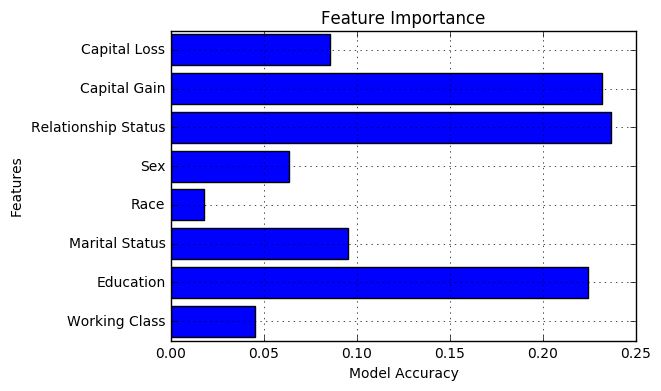

In [5]:
# fit an Extra Tree model to the data
extree = ExtraTreesClassifier()
extree.fit(X, y)

# display the relative importance of each attribute
relval = extree.feature_importances_

# horizontal bar plot of feature importance
pos = np.arange(8) + 0.5
plt.barh(pos, relval, align='center')
plt.title("Feature Importance")
plt.xlabel("Model Accuracy")
plt.ylabel("Features")
plt.yticks(pos, ('Working Class', 'Education', 'Marital Status', 'Race', 'Sex', 'Relationship Status', 'Capital Gain', 'Capital Loss'))
plt.grid(True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [7]:
# import
from sklearn.linear_model import LogisticRegression

# instantiate
logreg = LogisticRegression()

# fit
logreg.fit(X_train, y_train)

# predict
y_pred = logreg.predict(X_test)

print('LogReg %s' % metrics.accuracy_score(y_test, y_pred))

LogReg 0.833463541667


In [8]:
# KFolds and Cross_val_scores
kf = KFold(len(data), n_folds=10, shuffle=False)
print('KFold CrossValScore %s' % cross_val_score(logreg, X, y, cv=kf).mean())

KFold CrossValScore 0.807736668804


In [9]:
from sklearn.neighbors import KNeighborsClassifier
k_range = np.arange(1, 26)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
print(scores.index(max(scores)), max(scores))

20 0.853385416667


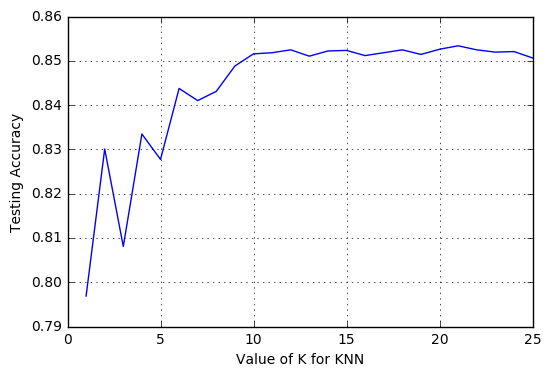

In [10]:
# plot the relationship between K and testing accuracy
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.grid(True)

In [11]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.85247395833333328

In [12]:
# create the numerical dummy columns for the features
dummies = pd.get_dummies(raw_data)

# del either the greater than 50K feature or less than 50K feature
del dummies['income_<=50K']
dummy_data = dummies.values

# shape the features and response 
X = dummy_data[:, :-1]
y = dummy_data[:, -1]
print(X.shape, y.shape)

# fit
gbc = GradientBoostingClassifier().fit(X_train, y_train)

print('GBC %s' % gbc.score(X_test, y_test))

(30718, 105) (30718,)
GBC 0.855078125


In [13]:
# create a feature numerically representative of different capital gains catergories 
def cap_split(row):
    if row['capital.gain'] > 0 and row['over50K'] == 1:
        return 1
    elif row['capital.gain'] > 0 and row['over50K'] == 0:
        return 2
    elif row['capital.gain'] <= 0 and row['over50K'] == 1:
        return 3
    else:
        return 4
    
data['cap_split'] = data.apply (lambda row: cap_split (row), axis=1)

In [14]:
# def that will display the percentage and absolute value on the pie chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

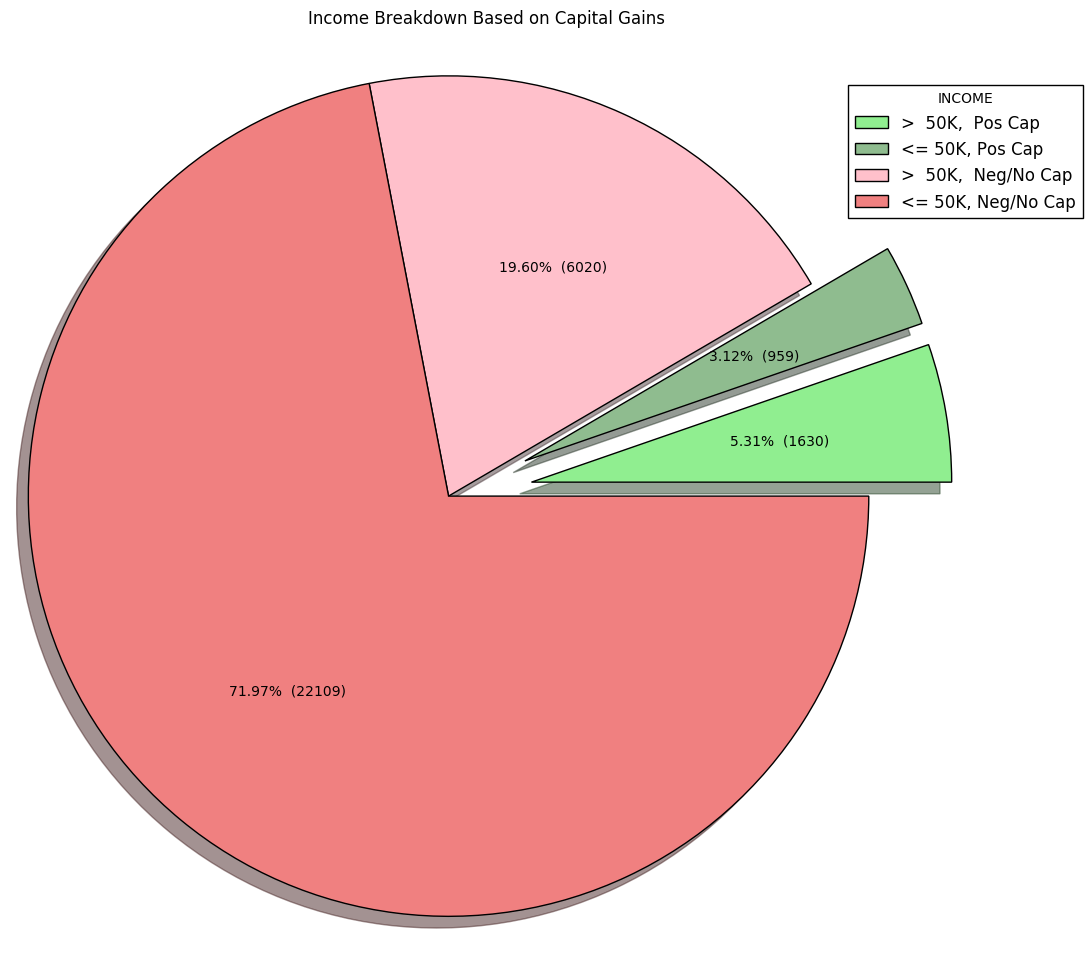

In [15]:
# pie chart displaying breakdown of all types of cap in relation to making over 50K
cap_split = data.cap_split.value_counts().sort_index()
colors = ['lightgreen', 'darkseagreen', 'pink', 'lightcoral']
explode = [0.2, 0.2, 0, 0]
label = ['>  50K,  Pos Cap', '<= 50K, Pos Cap', '>  50K,  Neg/No Cap', '<= 50K, Neg/No Cap']
fig = plt.figure(figsize=(12, 12)) 
ax = fig.add_subplot(1, 1, 1)
plt.pie(cap_split, shadow=True, colors=colors, explode=explode, autopct=make_autopct(cap_split))
plt.title('Income Breakdown Based on Capital Gains')
plt.axis('equal')
plt.legend(label, title='INCOME', bbox_to_anchor=(1.15, .95))

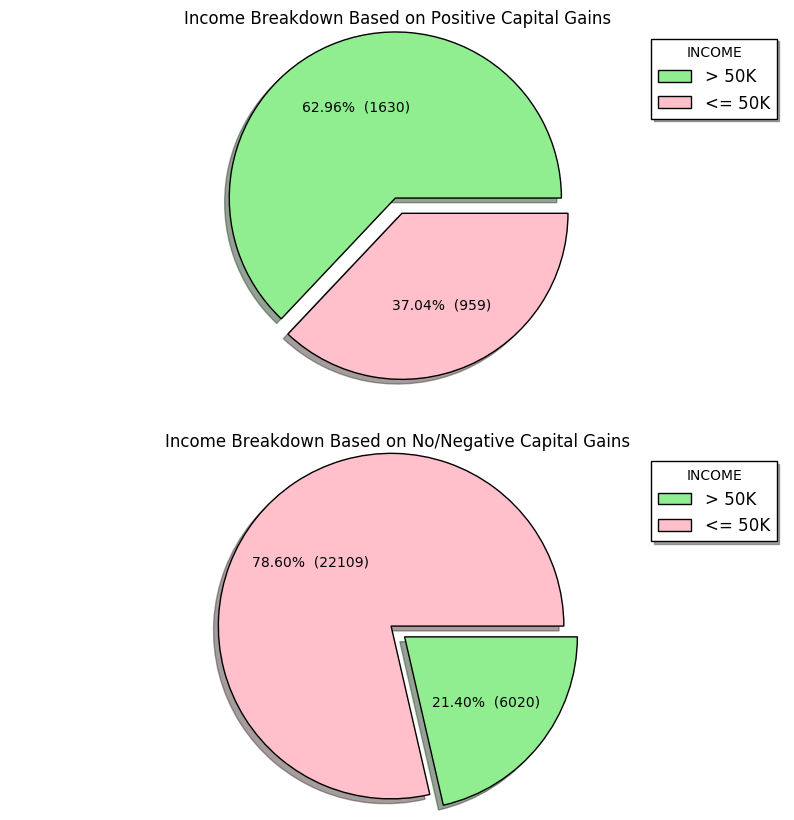

In [16]:
# pie charts separating the Pos Capital Gains vs. the Neg/No Capital Gains
import matplotlib.patches as mpatches
%matplotlib inline

caphigh = data[data['capital.gain'] > 0]
caplow = data[data['capital.gain'] <= 0]

caphigh_val = caphigh.over50K.value_counts()
caplow_val = caplow.over50K.value_counts()
colors1 = ['lightgreen', 'pink']
colors2 = ['pink', 'lightgreen']

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
plt.pie(caphigh_val, shadow=True, explode=[0.1, 0], colors=colors1, autopct=make_autopct(caphigh_val))
plt.axis('equal')
plt.title('Income Breakdown Based on Positive Capital Gains')
plt.legend(labels=['> 50K', '<= 50K'], frameon=True, shadow=True, title='INCOME')

ax2 = fig.add_subplot(2, 1, 2)
plt.pie(caplow_val, shadow=True, explode=[0.1, 0], colors=colors2, autopct=make_autopct(caplow_val))
plt.axis('equal')
plt.title('Income Breakdown Based on No/Negative Capital Gains')
ax2_patch1 = mpatches.Patch(facecolor='lightgreen',  edgecolor='black', label='> 50K')
ax2_patch2 = mpatches.Patch(facecolor='pink',  edgecolor='black', label='<= 50K')
plt.legend(handles=[ax2_patch1, ax2_patch2], frameon=True, shadow=True, title='INCOME')

plt.show()